# Forced pattern analysis of SST

Reading in SST data and performing low-frequency component analysis

In [1]:
%matplotlib inline

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
#import cftime

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

## Using `intake-esm` to get SST data
[Intake-esm](https://intake-esm.readthedocs.io) is a data cataloging utility that facilitates access to CMIP data. It's pretty awesome.

An `intake-esm` collection object establishes a link to a database that contains file locations and associated metadata (i.e. which experiement, model, etc. thet come from). 

### Opening a collection
First step is to open a collection by pointing to the collection definition file, which is a JSON file that conforms to the [ESM Collection Specification](https://github.com/NCAR/esm-collection-spec). 

The collection JSON files are stored locally in this repository for purposes of reproducibility---and because Cheyenne compute nodes don't have Internet access. 

The primary source for these files is the [intake-esm-datastore](https://github.com/NCAR/intake-esm-datastore) repository. Any changes made to these files should be pulled from that repo. For instance, the Pangeo cloud collection is available [here](https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json).

In [2]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
#col

`intake-esm` is build on top of [pandas](https://pandas.pydata.org/pandas-docs/stable). It is possible to view the `pandas.DataFrame` as follows.

In [3]:
#col.df.head()

It is possible to interact with the `DataFrame`; for instance, we can see what the "attributes" of the datasets are by printing the columns.

In [4]:
#col.df.columns

### Search and discovery

#### Finding unique entries
Let's query the data to see what models ("source_id"), experiments ("experiment_id") and temporal frequencies ("table_id") are available.

In [5]:
import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
#pprint.pprint(uni_dict, compact=True)

#### Searching for specific datasets

Let's find all the dissolved oxygen data at annual frequency from the ocean for the `historical` and `ssp585` experiments.

In [6]:
cat = col.search(experiment_id=['historical', 'ssp585'], table_id='Amon', variable_id='ts', grid_label='gn')
#cat.df

It might be desirable to get more specific. For instance, we may want to select only the models that have *both* `historical` and `ssp585` data. We coud do this as follows.

In [7]:
models = set(uni_dict['source_id']['values']) # all the models

for experiment_id in ['historical', 'ssp585']:
    query = dict(experiment_id=experiment_id, table_id='Amon', 
                 variable_id='ts', grid_label='gn')  
    cat = col.search(**query)
    models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

models = list(models)
models

['CESM2',
 'UKESM1-0-LL',
 'CESM2-WACCM',
 'CAMS-CSM1-0',
 'MRI-ESM2-0',
 'MIROC-ES2L',
 'FGOALS-g3',
 'CanESM5',
 'MIROC6',
 'NESM3',
 'BCC-CSM2-MR']

In [8]:
cat = col.search(experiment_id=['historical', 'ssp585'], table_id='Amon', 
                 variable_id='ts', grid_label='gn', source_id=models)
#cat.df

### Loading data

`intake-esm` enables loading data directly into an [xarray.Dataset](http://xarray.pydata.org/en/stable/api.html#dataset).

Note that data on the cloud are in 
[zarr](https://zarr.readthedocs.io/en/stable/) format and data on 
[glade](https://www2.cisl.ucar.edu/resources/storage-and-file-systems/glade-file-spaces) are stored as 
[netCDF](https://www.unidata.ucar.edu/software/netcdf/) files. This is opaque to the user.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

In [9]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': True})


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 22 group(s)


/glade/u/home/rwills/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/glade/u/home/rwills/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/glade/u/home/rwills/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/glade/u/home/rwills/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/glade/u/home/rwills/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'ts' has multi

`dset_dict` is a dictionary of `xarray.Dataset`'s; its keys are constructed to refer to compatible groups.

In [10]:
dset_dict.keys()

dict_keys(['CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn', 'CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn', 'CMIP.CAS.FGOALS-g3.historical.Amon.gn', 'CMIP.CAS.FGOALS-g3.ssp585.Amon.gn', 'CMIP.CCCma.CanESM5.historical.Amon.gn', 'CMIP.MIROC.MIROC-ES2L.historical.Amon.gn', 'CMIP.MIROC.MIROC6.historical.Amon.gn', 'CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn', 'CMIP.MRI.MRI-ESM2-0.historical.Amon.gn', 'CMIP.NCAR.CESM2.historical.Amon.gn', 'CMIP.NCAR.CESM2-WACCM.historical.Amon.gn', 'CMIP.NUIST.NESM3.historical.Amon.gn', 'ScenarioMIP.BCC.BCC-CSM2-MR.ssp585.Amon.gn', 'ScenarioMIP.CAMS.CAMS-CSM1-0.ssp585.Amon.gn', 'ScenarioMIP.CCCma.CanESM5.ssp585.Amon.gn', 'ScenarioMIP.MIROC.MIROC-ES2L.ssp585.Amon.gn', 'ScenarioMIP.MIROC.MIROC6.ssp585.Amon.gn', 'ScenarioMIP.MOHC.UKESM1-0-LL.ssp585.Amon.gn', 'ScenarioMIP.MRI.MRI-ESM2-0.ssp585.Amon.gn', 'ScenarioMIP.NCAR.CESM2.ssp585.Amon.gn', 'ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn', 'ScenarioMIP.NUIST.NESM3.ssp585.Amon.gn'])

We can access a particular dataset as follows.

In [11]:
# choose model here
ds_hist = dset_dict['CMIP.MIROC.MIROC6.historical.Amon.gn']
ds_ssp585 = dset_dict['ScenarioMIP.MIROC.MIROC6.ssp585.Amon.gn']

In [12]:
ds_hist.ts

<xarray.DataArray 'ts' (member_id: 10, time: 1980, lat: 128, lon: 256)>
dask.array<concatenate, shape=(10, 1980, 128, 256), dtype=float32, chunksize=(1, 1200, 128, 256), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U9 'r2i1p1f1' 'r5i1p1f1' ... 'r7i1p1f1' 'r6i1p1f1'
  * lon        (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat        (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
Attributes:
    standard_name:  surface_temperature
    long_name:      Surface Temperature
    comment:        Temperature of the lower boundary of the atmosphere
    units:          K
    original_name:  GRTS
    cell_methods:   area: time: mean
    cell_measures:  area: areacella

In [13]:
ds_hist = ds_hist.chunk({'member_id': 1, 'time': 1980})
ds_ssp585 = ds_ssp585.chunk({'member_id': 1, 'time': 1980})

### Get land fraction

As motivation for diving into more advanced manipulations with `intake-esm`, let's consider the task of getting access to grid information in the `Ofx` table_id.

In [14]:
cat_fx = col.search(experiment_id=['historical'], source_id=models, variable_id='sftlf', table_id='fx', grid_label='gn')
#cat_fx.df

In [15]:
df = cat_fx.df.copy()
df.drop_duplicates(subset=['source_id', 'variable_id'], inplace=True)
#df

Now, since we've only retained one ensemble member, we need to eliminate that column. If we omit this step, `intake-esm` will throw an error, complaining that different variables are present for each ensemble member. Setting the `member_id` column to NaN precludes attempts to join along the ensemble dimension.

After this final manipulation, we copy the `DataFrame` back to the collection object and proceed with loading the data.

In [16]:
df['member_id'] = np.nan
cat_fx.df = df

In [17]:
fx_dsets = cat_fx.to_dataset_dict(zarr_kwargs={'consolidated': True}, cdf_kwargs={'chunks': {}})


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 6 group(s)


/glade/u/home/rwills/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [18]:
fx_dsets.keys()

dict_keys(['CMIP.CCCma.CanESM5.historical.fx.gn', 'CMIP.MIROC.MIROC-ES2L.historical.fx.gn', 'CMIP.MIROC.MIROC6.historical.fx.gn', 'CMIP.MRI.MRI-ESM2-0.historical.fx.gn', 'CMIP.NCAR.CESM2.historical.fx.gn', 'CMIP.NCAR.CESM2-WACCM.historical.fx.gn'])

In [19]:
for key, ds in fx_dsets.items():
    print(ds.data_vars)

Data variables:
    lat_bnds  (lat, bnds) float64 dask.array<chunksize=(64, 2), meta=np.ndarray>
    lon_bnds  (lon, bnds) float64 dask.array<chunksize=(128, 2), meta=np.ndarray>
    type      |S4 ...
    sftlf     (lat, lon) float32 dask.array<chunksize=(64, 128), meta=np.ndarray>
Data variables:
    lat_bnds  (lat, bnds) float64 dask.array<chunksize=(64, 2), meta=np.ndarray>
    lon_bnds  (lon, bnds) float64 dask.array<chunksize=(128, 2), meta=np.ndarray>
    type      |S4 ...
    sftlf     (lat, lon) float32 dask.array<chunksize=(64, 128), meta=np.ndarray>
Data variables:
    lat_bnds  (lat, bnds) float64 dask.array<chunksize=(128, 2), meta=np.ndarray>
    lon_bnds  (lon, bnds) float64 dask.array<chunksize=(256, 2), meta=np.ndarray>
    type      |S4 ...
    sftlf     (lat, lon) float32 dask.array<chunksize=(128, 256), meta=np.ndarray>
Data variables:
    lat_bnds  (lat, bnds) float64 dask.array<chunksize=(160, 2), meta=np.ndarray>
    lon_bnds  (lon, bnds) float64 dask.array<chunks

In [20]:
lat=ds_hist['lat']
lon=ds_hist['lon']

In [21]:
members = ds_hist['member_id']
ne = np.shape(members)
ne

(10,)

In [22]:
members[0].values

array('r2i1p1f1', dtype='<U9')

In [23]:
ds_ssp585.time

<xarray.DataArray 'time' (time: 1032)>
array(['2015-01-16T12:00:00.000000000', '2015-02-15T00:00:00.000000000',
       '2015-03-16T12:00:00.000000000', ..., '2100-10-16T12:00:00.000000000',
       '2100-11-16T00:00:00.000000000', '2100-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

In [24]:
hist_amean=ds_hist.groupby('time.year').mean('time')
ssp585_amean=ds_ssp585.groupby('time.year').mean('time')

In [25]:
hist_amean = hist_amean - hist_amean.mean('year')
ssp585_amean = ssp585_amean - ssp585_amean.mean('year')

hist_amean_emean = hist_amean.mean('member_id')
ssp585_amean_emean = ssp585_amean.mean('member_id')

In [26]:
hist_clim=ds_hist.groupby('time.month').mean('time')
ssp585_clim=ds_ssp585.groupby('time.month').mean('time')

hist_clim_emean = hist_clim.mean('member_id')
ssp585_clim_emean = ssp585_clim.mean('member_id')

hist_anom = ds_hist.groupby('time.month') - hist_clim
ssp585_anom = ds_ssp585.groupby('time.month') - ssp585_clim

hist_anom_emean = hist_anom.mean('member_id')
ssp585_anom_emean = ssp585_anom.mean('member_id')

/glade/u/home/rwills/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1311: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]
/glade/u/home/rwills/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1311: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]


In [27]:
field = ssp585_anom_emean.ts.values

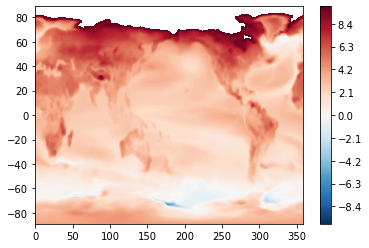

In [29]:
f=plt.figure()
plt.contourf(lon,lat,np.mean(field[912:1031,:,:],0)-np.mean(field[0:119,:,:],0),np.arange(-10,10.1,.1),cmap=plt.cm.RdBu_r)
cbar = plt.colorbar(extend='both')

In [30]:
# Preprocessing for Large Ensemble EOFs (with upscaling)

cosw = np.sqrt(np.cos(lat*np.pi/180))

X=hist_amean*cosw

X_concat=X.stack(index=['year','member_id'])
X_ensmean=X.mean('member_id')

T = X_ensmean.year

In [31]:
X_upscale = X_concat.coarsen(lon=2, lat = 2, boundary='trim').mean()
X_ensmean_upscale = X_ensmean.coarsen(lon = 2, lat = 2, boundary='trim').mean()

X_upscale_flat = X_upscale.stack(shape=['lat','lon'])
X_ensmean_upscale_flat = X_ensmean_upscale.stack(shape=['lat','lon'])

latu = X_upscale.lat.values
lonu = X_upscale.lon.values

In [32]:
%%time

# Large Ensemble EOFs (with upscaling)

u,s,v=np.linalg.svd(X_upscale_flat.ts.values/np.sqrt(len(T)-1))

eigvals=np.diag(s*s)

cosw = np.sqrt(np.cos(latu*np.pi/180))

# Dimension checks
#print(ds_upscale.shape)
#plt.contourf(ds_upscale.lon,ds_upscale.lat,ds_upscale[0,0,:,:])
#ds_upscale.lat_bins

CPU times: user 12min 54s, sys: 6min 53s, total: 19min 48s
Wall time: 32.4 s


In [37]:
Xe = X_ensmean_upscale_flat.ts.values
Xs = X_upscale_flat.ts.values

In [53]:
np.shape(Xe)

(165, 8192)

In [35]:
np.shape(S)

(1650, 200)

In [63]:
# Large Ensemble Forced Patterns

neof=200

# changed from u

S=np.matmul(v[:,0:neof],np.diag(1/s[0:neof]))
Sadj=np.matmul(np.diag(s[0:neof]),v[:,0:neof].T)

#EFPCs=np.matmul(ds_ensmean.values,S)
EFPCs=np.matmul(Xe,S)

gamma=np.cov(EFPCs.T)  #covariance matrix

u2,s2,v2=np.linalg.svd(gamma)
EFP=np.matmul(v2,Sadj)

#EFP_reshaped=EFP.reshape(neof,len(lat),len(lon))/cosw.values[None,:,None]
EFP_reshaped=EFP.reshape(neof,len(latu),len(lonu))/cosw[None,:,None]

#weights = np.matmul(S,v2.T).reshape(len(lat),len(lon),neof)*cosw.values[:,None,None]
weights = np.matmul(S,v2.T)
weights = weights.reshape(len(latu),len(lonu),neof)*cosw[:,None,None]

#weights=weights.reshape(len(lat)*len(lon),neof)
weights=weights.reshape(len(latu)*len(lonu),neof)

#EFCs= np.matmul(ds_flat.values.T,weights)
#EFC_emean = np.matmul(ds_ensmean.values,weights)

EFCs= np.matmul(Xs,weights)
EFC_emean = np.matmul(Xe,weights)

for ii in range(neof):
    if np.mean(EFP[ii,:]) < 0:
        EFP_reshaped[ii,:,:] = -EFP_reshaped[ii,:,:]
        EFP[ii,:] = -EFP[ii,:]
        EFCs[:,ii] = -EFCs[:,ii]
        EFC_emean[:,ii] = -EFC_emean[:,ii]

[21.98331838  4.91251756  2.60922402  2.05395058  1.39385426  1.21849208
  1.06243674  0.95219529  0.86292583  0.83352308  0.71786745  0.64270361
  0.61640773  0.58479905  0.57675368  0.52626992  0.49709684  0.46672858
  0.43340315  0.4215579 ]
[0.83818826 0.44851365 0.14199743 0.26041638 0.15821565 0.22992746
 0.19807961 0.14334419 0.1537022  0.17781663 0.13998572 0.19305072
 0.1813191  0.12764471 0.14942716 0.13121963 0.12828259 0.13014126
 0.14350297 0.14526741]


Text(0.5, 1.0, 'Signal-to-Noise Ratio')

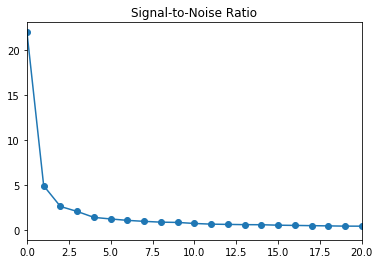

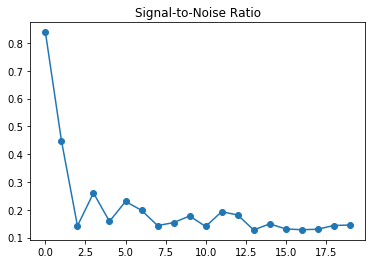

In [64]:
print(s2[0:20])
plt.plot(s2,marker='o')
plt.xlim(0,20)
plt.title('Signal-to-Noise Ratio')

s2_check = np.zeros(20)
for ii in range(20): 
    s2_check[ii] = np.mean(np.square(EFC_emean[:,ii]))/np.mean(np.square(EFCs[:,ii]))
    
print(s2_check)
f=plt.figure()
plt.plot(s2_check,marker='o')
plt.title('Signal-to-Noise Ratio')

In [65]:
EFP_reshaped[0,:,:] = EFP_reshaped[0,:,:]*np.std(EFCs[:,0])
EFP_reshaped[1,:,:] = EFP_reshaped[1,:,:]*np.std(EFCs[:,1])
EFP_reshaped[2,:,:] = EFP_reshaped[2,:,:]*np.std(EFCs[:,2])
EFC_emean[:,0] = EFC_emean[:,0]/np.std(EFCs[:,0])
EFC_emean[:,1] = EFC_emean[:,1]/np.std(EFCs[:,1])
EFC_emean[:,2] = EFC_emean[:,2]/np.std(EFCs[:,2])
EFCs[:,0] = EFCs[:,0]/np.std(EFCs[:,0])
EFCs[:,1] = EFCs[:,1]/np.std(EFCs[:,1])
EFCs[:,2] = EFCs[:,2]/np.std(EFCs[:,2])

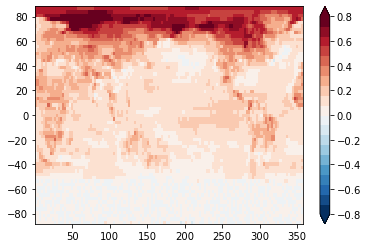

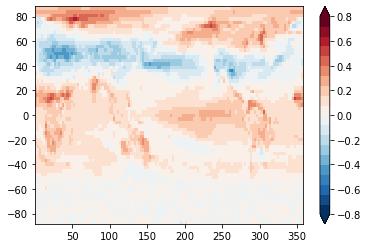

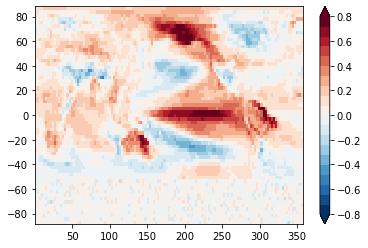

In [87]:
f=plt.figure()
plt.pcolormesh(lonu,latu,np.squeeze(EFP_reshaped[0,:,:]),cmap=plt.cm.get_cmap('RdBu_r',20))
plt.clim(-0.8,0.8)
plt.colorbar(extend='both')

f=plt.figure()
plt.pcolormesh(lonu,latu,np.squeeze(EFP_reshaped[1,:,:]),cmap=plt.cm.get_cmap('RdBu_r',20))
plt.clim(-0.8,0.8)
plt.colorbar(extend='both')

f=plt.figure()
plt.pcolormesh(lonu,latu,np.squeeze(EFP_reshaped[2,:,:]),cmap=plt.cm.get_cmap('RdBu_r',20))
plt.clim(-0.8,0.8)
plt.colorbar(extend='both')

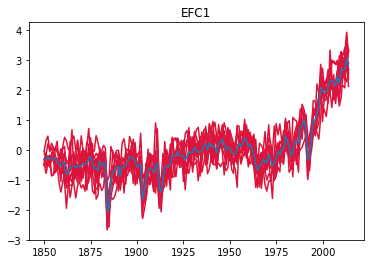

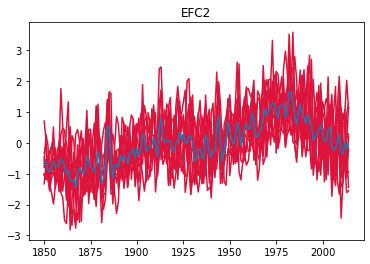

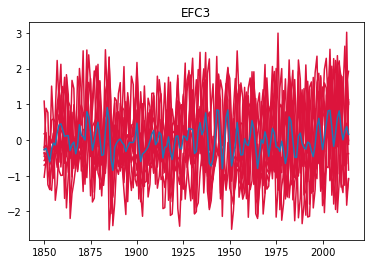

In [75]:
EFCs_reshape=EFCs.reshape(165,10,neof)
#plt.plot(np.std(EFCs,axis=0),marker='o')
#plt.xlim(0,20)
#plt.title('Standard Deviation of EFC')

for neof_plot in range(3): 
    f=plt.figure()
    [plt.plot(T.values,EFCs_reshape[:,mm,neof_plot],color='crimson') for mm in range(10)];
    plt.plot(T.values,EFC_emean[:,neof_plot])
    plt.title('EFC'+str(neof_plot+1))

In [72]:
T = X_ensmean.year

In [88]:
T

<xarray.DataArray 'year' (year: 165)>
array([1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861,
       1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873,
       1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885,
       1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897,
       1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909,
       1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921,
       1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1